In [1]:
import os 
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))

In [2]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from sklearn.model_selection import train_test_split

# Own library imports
from utilities.utils import TensOps
from utilities.operators.zero_order import Mx, My
from utilities.kernels.derivative import DerivativeKernels

# Function from this project
from utils.folders import create_folder
from utils.load_data import load_data
from utils.checkpoints import load_results

# Import model
from architectures.pgnniv_baseline import PGNNIVBaseline

In [3]:
# Creamos los paths para las distintas carpetas
ROOT_PATH = r'C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data\sigmoid_nonlinear_1000\sigmoid_nonlinear_1000.pkl')
RESULTS_FOLDER_PATH_1000 = os.path.join(ROOT_PATH, r'results\transfer_learning_1000')

BASELINE_PATH_1000 = os.path.join(ROOT_PATH, r'results\transfer_learning_1000\baseline')
TRANSFER_PATH_1000 = os.path.join(ROOT_PATH, r'results\transfer_learning_1000\transfer')
FINETUNING_PATH_1000 = os.path.join(ROOT_PATH, r'results\transfer_learning_1000\finetuning')

# Creamos las carpetas que sean necesarias (si ya están creadas se avisará de ello)
create_folder(RESULTS_FOLDER_PATH_1000)
create_folder(BASELINE_PATH_1000)
create_folder(TRANSFER_PATH_1000)
create_folder(FINETUNING_PATH_1000)

dataset_1000 = load_data(DATA_PATH)

Folder already exists at: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\results\transfer_learning_1000
Folder already exists at: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\results\transfer_learning_1000\baseline
Folder already exists at: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\results\transfer_learning_1000\transfer
Folder already exists at: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\results\transfer_learning_1000\finetuning
Data successfully loaded from: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data\sigmoid_nonlinear_1000\sigmoid_nonlinear_1000.pkl


In [4]:
# Creamos los paths para las distintas carpetas
ROOT_PATH = r'C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data\sigmoid_nonlinear_100\sigmoid_nonlinear_100.pkl')
RESULTS_FOLDER_PATH_100 = os.path.join(ROOT_PATH, r'results\transfer_learning_100')

BASELINE_PATH_100 = os.path.join(ROOT_PATH, r'results\transfer_learning_100\baseline')
TRANSFER_PATH_100 = os.path.join(ROOT_PATH, r'results\transfer_learning_100\transfer')
FINETUNING_PATH_100 = os.path.join(ROOT_PATH, r'results\transfer_learning_100\finetuning')

# Creamos las carpetas que sean necesarias (si ya están creadas se avisará de ello)
create_folder(RESULTS_FOLDER_PATH_100)
create_folder(BASELINE_PATH_100)
create_folder(TRANSFER_PATH_100)
create_folder(FINETUNING_PATH_100)

dataset_100 = load_data(DATA_PATH)

Folder already exists at: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\results\transfer_learning_100
Folder already exists at: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\results\transfer_learning_100\baseline
Folder already exists at: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\results\transfer_learning_100\transfer
Folder already exists at: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\results\transfer_learning_100\finetuning
Data successfully loaded from: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data\sigmoid_nonlinear_100\sigmoid_nonlinear_100.pkl


In [5]:
# Convolutional filters to derivate
dx = dataset_100['x_step_size']
dy = dataset_100['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

In [6]:
DEVICE = torch.device("cpu")

print(f"Using device: {DEVICE}")

Using device: cpu


In [7]:
def smooth_curve(data, window_size=1000):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

def cm_to_in(cm):
    return cm * 0.393701

def normalize_list(lst):
    max_value = np.max(lst)
    return [x / max_value for x in lst]

def relative_error(validation, prediction, dx=dx, dy=dy):
    
    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

    return prediction_error

def compute_quartiles(error_array):
    return (np.percentile(error_array, 25),
            np.percentile(error_array, 50),
            np.percentile(error_array, 75))

def compute_explanatory_error(K_predicted, K_true, u_vals):
    diff_squared = (K_predicted - K_true) ** 2
    true_squared = K_true ** 2
    er = (np.sqrt(np.trapz(diff_squared.flatten(), u_vals))) / (np.sqrt(np.trapz(true_squared.flatten(), u_vals)))
    return er

linewidth = 1.5  
title_fontsize = 14  
label_fontsize = 14  
legend_fontsize = 12 
tick_fontsize = 11  

# plt.rc('text', usetex=True)
plt.rc('font', family='serif')

posX = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en X
posY = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en Y
width = cm_to_in(12)  # ancho de la imagen
height = cm_to_in(8) # alto de la imagen

color = [0.1, 0, 0.8]  # triplete RGB, valores entre 0 y 1
subplot_adjust_left = cm_to_in(0.15)
subplot_adjust_bottom = cm_to_in(0.15)

In [8]:
# Train data splitting in train/test
X = torch.tensor(dataset_100['X_train'], dtype=torch.float32).unsqueeze(1)
y = torch.tensor(dataset_100['y_train'], dtype=torch.float32).unsqueeze(1)
K = torch.tensor(dataset_100['k_train'], dtype=torch.float32).unsqueeze(1)
f = torch.tensor(dataset_100['f_train'], dtype=torch.float32).unsqueeze(1)

X_train, X_test, y_train, y_test, K_train, K_test, f_train, f_test = train_test_split(X, y, K, f, test_size=0.3, random_state=42)

# Data processing and adequacy with our TensOps library
X_train = X_train.to(DEVICE)
y_train = TensOps(y_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
K_train = TensOps(K_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
f_train = TensOps(f_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

In [9]:
n_modes = 10

# Predictive network architecture
input_shape = X_train[0].shape
predictive_layers = [20, 10, n_modes, 10, 20]
predictive_output = y_train.values[0].shape

# Explanatory network architecture
explanatory_input = Mx(My(y_train)).values[0].shape
explanatory_layers = [10, 10]
explanatory_output = Mx(My(f_train)).values[0].shape

# Other parameters
n_filters_explanatory = 5

In [10]:
baseline_pgnniv = PGNNIVBaseline(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
optimizer = torch.optim.Adam(baseline_pgnniv.parameters(), lr=1e-4)
baseline_pgnniv, lists_bl = load_results(baseline_pgnniv, optimizer, BASELINE_PATH_100, map_location=torch.device('cpu'))

transfer_pgnniv = PGNNIVBaseline(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
optimizer = torch.optim.Adam(transfer_pgnniv.parameters(), lr=1e-4)
transfer_pgnniv, lists_tl = load_results(transfer_pgnniv, optimizer, TRANSFER_PATH_100, map_location=torch.device('cpu'))

finetuning_pgnniv = PGNNIVBaseline(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
optimizer = torch.optim.Adam(finetuning_pgnniv.parameters(), lr=1e-4)
finetuning_pgnniv, lists_ft = load_results(finetuning_pgnniv, optimizer, FINETUNING_PATH_100, map_location=torch.device('cpu'))

train_loss_list_bl_100 = lists_bl['train_total_loss_list']
train_loss_list_ft_100 = lists_ft['train_total_loss_list']
train_loss_list_tl_100 = lists_tl['train_total_loss_list']

test_loss_list_bl_100 = lists_bl['test_total_loss_list']
test_loss_list_ft_100 = lists_ft['test_total_loss_list']
test_loss_list_tl_100 = lists_tl['test_total_loss_list']

time_list_bl_100 = lists_bl['time_list']
time_list_ft_100 = lists_ft['time_list']
time_list_tl_100 = lists_tl['time_list']

In [11]:
# Calcular tiempos en minutos
baseline_time = np.cumsum(lists_bl['time_list'])[-1] / 60
finetuning_time = np.cumsum(lists_ft['time_list'])[-1] / 60
transfer_learning_time = np.cumsum(lists_tl['time_list'])[-1] / 60

# Calcular reducciones porcentuales
finetuning_reduction = (baseline_time - finetuning_time) / baseline_time * 100
transfer_learning_reduction = (baseline_time - transfer_learning_time) / baseline_time * 100

# Imprimir resultados
print(f"Baseline time: {baseline_time:.2f} min")
print(f"Finetuning time: {finetuning_time:.2f} min ({finetuning_reduction:.1f}% faster)")
print(f"Transfer learning time: {transfer_learning_time:.2f} min ({transfer_learning_reduction:.1f}% faster)")

Baseline time: 18.39 min
Finetuning time: 18.05 min (1.9% faster)
Transfer learning time: 15.93 min (13.4% faster)


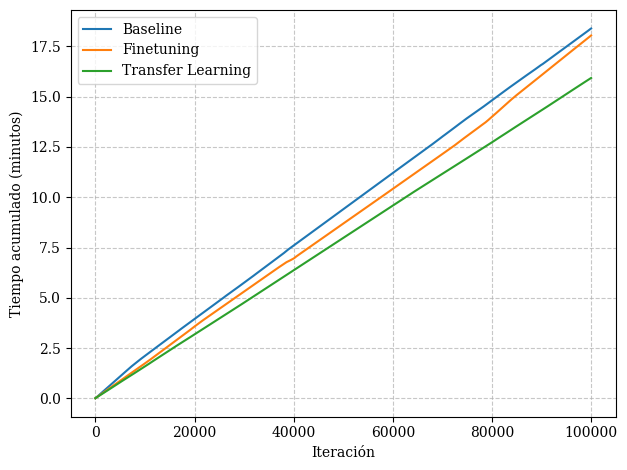

In [12]:
# Obtener el tiempo acumulado en minutos
baseline_cumsum = np.cumsum(lists_bl['time_list']) / 60
finetuning_cumsum = np.cumsum(lists_ft['time_list']) / 60
transfer_learning_cumsum = np.cumsum(lists_tl['time_list']) / 60

# Crear el gráfico
plt.figure()
plt.plot(baseline_cumsum, label='Baseline')
plt.plot(finetuning_cumsum, label='Finetuning')
plt.plot(transfer_learning_cumsum, label='Transfer Learning')

# Añadir etiquetas y leyenda
plt.xlabel('Iteración')
plt.ylabel('Tiempo acumulado (minutos)')
# plt.title('Tiempo acumulado de entrenamiento')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [13]:
baseline_pgnniv_1000 = PGNNIVBaseline(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
optimizer = torch.optim.Adam(baseline_pgnniv_1000.parameters(), lr=1e-4)
baseline_pgnniv_1000, lists_bl = load_results(baseline_pgnniv_1000, optimizer, BASELINE_PATH_1000, map_location=torch.device('cpu'))

transfer_pgnniv_1000 = PGNNIVBaseline(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
optimizer = torch.optim.Adam(transfer_pgnniv_1000.parameters(), lr=1e-4)
transfer_pgnniv_1000, lists_tl = load_results(transfer_pgnniv_1000, optimizer, TRANSFER_PATH_1000, map_location=torch.device('cpu'))

finetuning_pgnniv_1000 = PGNNIVBaseline(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
optimizer = torch.optim.Adam(finetuning_pgnniv_1000.parameters(), lr=1e-4)
finetuning_pgnniv_1000, lists_ft = load_results(finetuning_pgnniv_1000, optimizer, FINETUNING_PATH_1000, map_location=torch.device('cpu'))

train_loss_list_bl_1000 = lists_bl['train_total_loss_list']
train_loss_list_ft_1000 = lists_ft['train_total_loss_list']
train_loss_list_tl_1000 = lists_tl['train_total_loss_list']

test_loss_list_bl_1000 = lists_bl['test_total_loss_list']
test_loss_list_ft_1000 = lists_ft['test_total_loss_list']
test_loss_list_tl_1000 = lists_tl['test_total_loss_list']

time_list_bl_1000 = lists_bl['time_list']
time_list_ft_1000 = lists_ft['time_list']
time_list_tl_1000 = lists_tl['time_list']

In [14]:
# Calcular tiempos en minutos
baseline_time = np.cumsum(lists_bl['time_list'])[-1] / 60
finetuning_time = np.cumsum(lists_ft['time_list'])[-1] / 60
transfer_learning_time = np.cumsum(lists_tl['time_list'])[-1] / 60

# Calcular reducciones porcentuales
finetuning_reduction = (baseline_time - finetuning_time) / baseline_time * 100
transfer_learning_reduction = (baseline_time - transfer_learning_time) / baseline_time * 100

# Imprimir resultados
print(f"Baseline time: {baseline_time:.2f} min")
print(f"Finetuning time: {finetuning_time:.2f} min ({finetuning_reduction:.1f}% faster)")
print(f"Transfer learning time: {transfer_learning_time:.2f} min ({transfer_learning_reduction:.1f}% faster)")

Baseline time: 168.93 min
Finetuning time: 166.67 min (1.3% faster)
Transfer learning time: 126.91 min (24.9% faster)


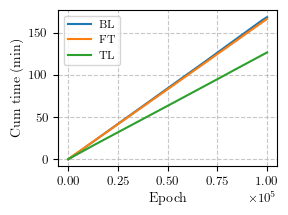

In [15]:
# Calcular el tiempo acumulado en minutos
baseline_cumsum = np.cumsum(lists_bl['time_list']) / 60
finetuning_cumsum = np.cumsum(lists_ft['time_list']) / 60
transfer_learning_cumsum = np.cumsum(lists_tl['time_list']) / 60

# Iteraciones
x_bl = np.arange(1, len(baseline_cumsum) + 1)
x_ft = np.arange(1, len(finetuning_cumsum) + 1)
x_tl = np.arange(1, len(transfer_learning_cumsum) + 1)

# Calcular pendientes (recta que pasa por el origen)
m_bl = np.dot(x_bl, baseline_cumsum) / np.dot(x_bl, x_bl)
m_ft = np.dot(x_ft, finetuning_cumsum) / np.dot(x_ft, x_ft)
m_tl = np.dot(x_tl, transfer_learning_cumsum) / np.dot(x_tl, x_tl)


# Función para formatear los xticks en formato científico estilo LaTeX
def sci_latex_format(x, _):
    if x == 0:
        return r"$0$"
    mantissa, exponent = f"{x:.1e}".split('e')
    return r"$" + f"10^{{{int(exponent)}}}" + r"$"

# Función para formatear los gradientes
def format_grad_latex(value):
    mantissa, exponent = f"{value:.2e}".split('e')
    return r"$\mathrm{{grad}} = " + f"{float(mantissa):.2f} \\times 10^{{{int(exponent)}}}" + r"$"

with plt.rc_context({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 10,
    "figure.figsize": (3.3*0.9, 2.5*0.9),
    "axes.labelsize": 10,
    "legend.fontsize": 8,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
}):
    plt.figure()

    # Etiquetas con gradiente formateado
    label_bl = f'BL'
    label_ft = f'FT'
    label_tl = f'TL'

    # Trazar
    plt.plot(baseline_cumsum, label=label_bl)
    plt.plot(finetuning_cumsum, label=label_ft)
    plt.plot(transfer_learning_cumsum, label=label_tl)

    # Etiquetas de los ejes
    plt.xlabel(r'Epoch')
    plt.ylabel(r'Cum time (min)')

    # Formatear el eje de las épocas (eje x) en notación científica
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    # Leyenda y estética
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    plt.savefig('transfer_learning_cumtime_N1000.pdf', bbox_inches='tight', format='pdf')
    plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import builtins

# Extraemos los arrays (omite el primer elemento)
bl_1000 = np.array(time_list_bl_1000)[1:]
ft_1000 = np.array(time_list_ft_1000)[1:]
tl_1000 = np.array(time_list_tl_1000)[1:]

bl_100 = np.array(time_list_bl_100)[1:]
ft_100 = np.array(time_list_ft_100)[1:]
tl_100 = np.array(time_list_tl_100)[1:]


min_len_bl = builtins.min(len(bl_1000), len(bl_100))
min_len_ft = builtins.min(len(ft_1000), len(ft_100))
min_len_tl = builtins.min(len(tl_1000), len(tl_100))


# Calculamos proporciones elemento a elemento
prop_bl = bl_1000[:min_len_bl] / bl_100[:min_len_bl]
prop_ft = ft_1000[:min_len_ft] / ft_100[:min_len_ft]
prop_tl = tl_1000[:min_len_tl] / tl_100[:min_len_tl]

# Función para media y desviación estándar
def stats(arr):
    return np.mean(arr), np.std(arr)

# Calculamos media y std para las proporciones
mean_bl, std_bl = stats(prop_bl)
mean_ft, std_ft = stats(prop_ft)
mean_tl, std_tl = stats(prop_tl)

print("Proporciones (Tiempo 1000 / Tiempo 100) por par de muestras:")
print(f"Baseline - Media: {mean_bl:.4f}, Desviación estándar: {std_bl:.4f}")
print(f"Fine-tuning - Media: {mean_ft:.4f}, Desviación estándar: {std_ft:.4f}")
print(f"Transfer Learning - Media: {mean_tl:.4f}, Desviación estándar: {std_tl:.4f}")

# Gráfico de barras con media y barra de error (std)
methods = ['Baseline', 'Fine-tuning', 'Transfer Learning']
means = [mean_bl, mean_ft, mean_tl]
stds = [std_bl, std_ft, std_tl]

Proporciones (Tiempo 1000 / Tiempo 100) por par de muestras:
Baseline - Media: 9.2394, Desviación estándar: 0.9435
Fine-tuning - Media: 9.3304, Desviación estándar: 1.1635
Transfer Learning - Media: 7.9955, Desviación estándar: 0.5590


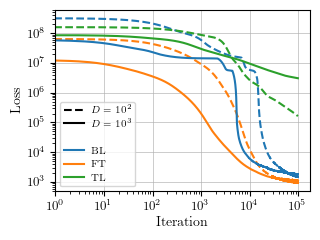

In [17]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Aplicamos el contexto de estilo
with plt.rc_context({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 10,
    "figure.figsize": (3.3, 2.5),
    "axes.labelsize": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
}):
    plt.figure()

    # Curvas N = 100 (línea discontinua)
    plt.plot(smooth_curve(train_loss_list_bl_100), label=None, linestyle='--', color='C0')
    plt.plot(smooth_curve(train_loss_list_ft_100), label=None, linestyle='--', color='C1')
    plt.plot(smooth_curve(train_loss_list_tl_100), label=None, linestyle='--', color='C2')

    # Curvas N = 1000 (línea sólida)
    plt.plot(smooth_curve(train_loss_list_bl_1000), label=None, linestyle='-', color='C0')
    plt.plot(smooth_curve(train_loss_list_ft_1000), label=None, linestyle='-', color='C1')
    plt.plot(smooth_curve(train_loss_list_tl_1000), label=None, linestyle='-', color='C2')

    # Etiquetas
    plt.xlabel(r'Iteration')
    plt.ylabel(r'Loss')

    # Ejes y escala
    plt.grid(True, linewidth=0.5, alpha=0.9)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(left=1)
    
    # Crear leyenda estratificada
    custom_lines = [
        Line2D([0], [0], color='black', linestyle='--', label=r'$D=10^2$'),
        Line2D([0], [0], color='black', linestyle='-', label=r'$D=10^3$'),
        Line2D([0], [0], color='black', linestyle=' ', label=r' '),
        Line2D([0], [0], color='C0', linestyle='-', label='BL'),
        Line2D([0], [0], color='C1', linestyle='-', label='FT'),
        Line2D([0], [0], color='C2', linestyle='-', label='TL'),
    ]
    plt.legend(handles=custom_lines, loc='lower left', ncol=1, frameon=True)

    plt.tight_layout()

    plt.savefig('transfer_learning_convergence.pdf', bbox_inches='tight', format='pdf')
    plt.show()


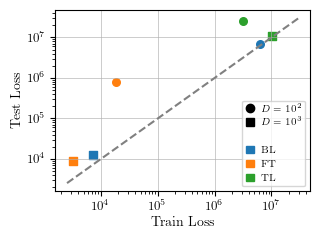

In [18]:
import matplotlib.pyplot as plt

# Define the indices que quieres mostrar
indices = [1, 1000, 5000, 9000]

# Extrae los valores correspondientes de cada lista (asegúrate de que estas listas tienen al menos hasta el índice 10000)
bl_values_1000_train = [smooth_curve(train_loss_list_bl_1000)[i] for i in indices][-1]
ft_values_1000_train = [smooth_curve(train_loss_list_ft_1000)[i] for i in indices][-1]
tl_values_1000_train = [smooth_curve(train_loss_list_tl_1000)[i] for i in indices][-1]

bl_values_100_train = [smooth_curve(train_loss_list_bl_100)[i] for i in indices][-1]
ft_values_100_train = [smooth_curve(train_loss_list_ft_100)[i] for i in indices][-1]
tl_values_100_train = [smooth_curve(train_loss_list_tl_100)[i] for i in indices][-1]

bl_values_1000_test = [smooth_curve(test_loss_list_bl_1000)[i] for i in indices][-1]
ft_values_1000_test = [smooth_curve(test_loss_list_ft_1000)[i] for i in indices][-1]
tl_values_1000_test = [smooth_curve(test_loss_list_tl_1000)[i] for i in indices][-1]

bl_values_100_test = [smooth_curve(test_loss_list_bl_100)[i] for i in indices][-1]
ft_values_100_test = [smooth_curve(test_loss_list_ft_100)[i] for i in indices][-1]
tl_values_100_test = [smooth_curve(test_loss_list_tl_100)[i] for i in indices][-1]

# Combine into arrays
train_losses = np.array([
    bl_values_100_train,
    ft_values_100_train,
    tl_values_100_train,
    bl_values_1000_train,
    ft_values_1000_train,
    tl_values_1000_train
])

test_losses = np.array([
    bl_values_100_test,
    ft_values_100_test,
    tl_values_100_test,
    bl_values_1000_test,
    ft_values_1000_test,
    tl_values_1000_test
])

labels = ['bl_100', 'ft_100', 'tl_100', 'bl_1000', 'ft_1000', 'tl_1000']
colors = ['C0', 'C1', 'C2', 'C0', 'C1', 'C2']
markers = ['o'] * 3 + ['s'] * 3  # o for 100, s for 1000

with plt.rc_context({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 10,
    "figure.figsize": (3.3, 2.5),  # Aproximadamente 0.45\linewidth
    "axes.labelsize": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
}):
    
    plt.figure()
    for i in range(len(train_losses)):
        plt.scatter(train_losses[i], test_losses[i], label=labels[i], color=colors[i], marker=markers[i], s=30)

    min_val = min(train_losses.min(), test_losses.min()) * 0.8
    max_val = max(train_losses.max(), test_losses.max()) * 1.2
    plt.plot([min_val, max_val], [min_val, max_val], '--', color='gray')

    legend_elements = [
        # Subleyenda: Tamaño del conjunto de datos (por marcador)
        # Line2D([0], [0], marker=' ', color='gray', linestyle='None',
        #        markersize=7, label=r'\textbf{Dataset}'),
        Line2D([0], [0], marker='o', color='black', linestyle='None', markersize=6, label=r'$D=10^2$'),
        Line2D([0], [0], marker='s', color='black', linestyle='None', markersize=6, label=r'$D=10^3$'),

        # Espaciador visual
        Line2D([0], [0], color='white', linestyle='None', label=''),

        # Subleyenda: Método (por color)
        # Line2D([0], [0], color='gray', linestyle=' ', label=r'\textbf{Model}'),
        mpatches.Patch(color='C0', label='BL'),
        mpatches.Patch(color='C1', label='FT'),
        mpatches.Patch(color='C2', label='TL'),
    ]

    plt.legend(handles=legend_elements, loc='lower right', frameon=True, ncol=1, handlelength=0.8, handleheight=0.8)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Train Loss')
    plt.ylabel('Test Loss')
    # plt.title('Train vs Test Loss')
    plt.grid(True, linewidth=0.5, alpha=0.9)
    plt.tight_layout()

    plt.savefig('transfer_learning_overfitting.pdf', bbox_inches='tight', format='pdf')
    plt.show()

In [19]:
X_val = torch.tensor(dataset_100['X_val'], dtype=torch.float32).unsqueeze(1)
y_val = TensOps(torch.tensor(dataset_100['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

u_min = y_val.values.flatten().min()
u_max = y_val.values.flatten().max()
steps = 1000

u_for_validating = torch.linspace(u_min, u_max, steps=steps).view(steps, 1, 1, 1)
K_for_validating = 1/(1 + np.exp(-5*(u_for_validating-1.5))).detach().cpu().numpy()

K_baseline = baseline_pgnniv.explanatory(u_for_validating.to(DEVICE)).detach().cpu().numpy()
K_transfer = transfer_pgnniv.explanatory(u_for_validating.to(DEVICE)).detach().cpu().numpy()
K_finetuning = finetuning_pgnniv.explanatory(u_for_validating.to(DEVICE)).detach().cpu().numpy()

u_vals = u_for_validating.numpy().flatten()
K_true = K_for_validating  # Asumiendo que ya es un numpy array

K_baseline = baseline_pgnniv.explanatory(u_for_validating.to(DEVICE)).detach().cpu().numpy()
K_transfer = transfer_pgnniv.explanatory(u_for_validating.to(DEVICE)).detach().cpu().numpy()
K_finetuning = finetuning_pgnniv.explanatory(u_for_validating.to(DEVICE)).detach().cpu().numpy()

er_baseline = compute_explanatory_error(K_baseline, K_true, u_vals)
er_transfer = compute_explanatory_error(K_transfer, K_true, u_vals)
er_finetuning = compute_explanatory_error(K_finetuning, K_true, u_vals)

# Obtener valores verdaderos de u
u_true = y_val.values.detach().numpy()

# Obtener predicciones de cada modelo
u_pred_baseline = baseline_pgnniv(X_val)[0].detach().numpy()
u_pred_transfer = transfer_pgnniv(X_val)[0].detach().numpy()
u_pred_finetuning = finetuning_pgnniv(X_val)[0].detach().numpy()

# Calcular errores relativos
er_u_baseline = relative_error(u_true, u_pred_baseline).flatten()
er_u_transfer = relative_error(u_true, u_pred_transfer).flatten()
er_u_finetuning = relative_error(u_true, u_pred_finetuning).flatten()

erQ1_b, erQ2_b, erQ3_b = compute_quartiles(er_u_baseline)
erQ1_t, erQ2_t, erQ3_t = compute_quartiles(er_u_transfer)
erQ1_f, erQ2_f, erQ3_f = compute_quartiles(er_u_finetuning)

er_u_baseline_100 = er_u_baseline
er_u_transfer_100 = er_u_transfer
er_u_finetuning_100 = er_u_finetuning

In [20]:
def format_error_latex(error):
    exponent = int(np.floor(np.log10(abs(error)))) if error != 0 else 0
    base = error / 10**exponent if error != 0 else 0
    return rf"$\epsilon_r^{{\mathrm{{exp}}}} = {base:.2f} \times 10^{{{exponent}}}$"

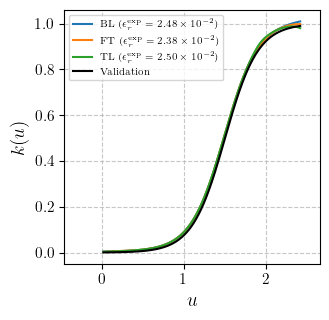

In [21]:
with plt.rc_context({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 10,
    "figure.figsize": (3.3, 3.3),  # Aproximadamente 0.45\linewidth
    "axes.labelsize": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
}):

    plt.figure()
    plt.plot(u_for_validating.flatten(), K_baseline.flatten(), label=f'BL ({format_error_latex(er_baseline)})', linewidth=1.5, alpha=1)
    plt.plot(u_for_validating.flatten(), K_finetuning.flatten(), label=f'FT ({format_error_latex(er_finetuning)})', linewidth=1.5, alpha=1)
    plt.plot(u_for_validating.flatten(), K_transfer.flatten(), label=f'TL ({format_error_latex(er_transfer)})', linewidth=1.5, alpha=1)
    plt.plot(u_for_validating.flatten(), K_for_validating.flatten(), label='Validation', color='black', linewidth=1.5, alpha=1)

    plt.xlabel('$u$', fontsize=label_fontsize)
    plt.ylabel('$k(u)$', fontsize=label_fontsize)
    # plt.title('Lineal homogeneous normalized learning curves', fontsize=s)

    plt.grid(True, linestyle='--', alpha=0.7)
    # Obtener la leyenda actual y cambiar el orden
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0, 1, 2, 3]  # Cambiar el orden de las etiquetas aquí (Validation primero, Prediction segundo)
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='upper left')
    plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

    min = torch.min(u_for_validating.flatten()) - 0.2*(torch.max(u_for_validating.flatten() - torch.min(u_for_validating.flatten())))
    max = torch.max(u_for_validating.flatten()) + 0.1*(torch.max(u_for_validating.flatten() - torch.min(u_for_validating.flatten())))

    plt.xlim(min, max)

    plt.savefig('transfer_learning_N100.pdf', bbox_inches='tight', format='pdf')
    plt.show()

In [22]:
print("\n===== Summary of Errors (N = 100) =====\n")
print(f"{'Model':<12} | {'er(K)':>10} | {'er(u) Q1':>10} | {'er(u) Q2':>10} | {'er(u) Q3':>10} |")
print("-" * 66)
print(f"{'Baseline':<12} | {er_baseline:>10.2e} | {erQ1_b:>10.2e} | {erQ2_b:>10.2e} | {erQ3_b:>10.2e} |")
print(f"{'Finetuning':<12} | {er_finetuning:>10.2e} | {erQ1_f:>10.2e} | {erQ2_f:>10.2e} | {erQ3_f:>10.2e} |")
print(f"{'Transfer':<12} | {er_transfer:>10.2e} | {erQ1_t:>10.2e} | {erQ2_t:>10.2e} | {erQ3_t:>10.2e} |")


===== Summary of Errors (N = 100) =====

Model        |      er(K) |   er(u) Q1 |   er(u) Q2 |   er(u) Q3 |
------------------------------------------------------------------
Baseline     |   2.48e-02 |   2.31e-03 |   6.06e-03 |   1.05e-02 |
Finetuning   |   2.38e-02 |   6.04e-03 |   1.46e-02 |   2.59e-02 |
Transfer     |   2.50e-02 |   5.78e-02 |   1.36e-01 |   3.01e-01 |


In [23]:
X_val = torch.tensor(dataset_1000['X_val'], dtype=torch.float32).unsqueeze(1)
y_val = TensOps(torch.tensor(dataset_1000['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

u_min = y_val.values.flatten().min()
u_max = y_val.values.flatten().max()
steps = 1000

u_for_validating = torch.linspace(u_min, u_max, steps=steps).view(steps, 1, 1, 1)
K_for_validating = 1/(1 + np.exp(-5*(u_for_validating-1.5))).detach().cpu().numpy()

K_baseline = baseline_pgnniv_1000.explanatory(u_for_validating.to(DEVICE)).detach().cpu().numpy()
K_transfer = transfer_pgnniv_1000.explanatory(u_for_validating.to(DEVICE)).detach().cpu().numpy()
K_finetuning = finetuning_pgnniv_1000.explanatory(u_for_validating.to(DEVICE)).detach().cpu().numpy()

u_vals = u_for_validating.numpy().flatten()
K_true = K_for_validating  # Asumiendo que ya es un numpy array

K_baseline = baseline_pgnniv_1000.explanatory(u_for_validating.to(DEVICE)).detach().cpu().numpy()
K_transfer = transfer_pgnniv_1000.explanatory(u_for_validating.to(DEVICE)).detach().cpu().numpy()
K_finetuning = finetuning_pgnniv_1000.explanatory(u_for_validating.to(DEVICE)).detach().cpu().numpy()

er_baseline = compute_explanatory_error(K_baseline, K_true, u_vals)
er_transfer = compute_explanatory_error(K_transfer, K_true, u_vals)
er_finetuning = compute_explanatory_error(K_finetuning, K_true, u_vals)

# Obtener valores verdaderos de u
u_true = y_val.values.detach().numpy()

# Obtener predicciones de cada modelo
u_pred_baseline = baseline_pgnniv_1000(X_val)[0].detach().numpy()
u_pred_transfer = transfer_pgnniv_1000(X_val)[0].detach().numpy()
u_pred_finetuning = finetuning_pgnniv_1000(X_val)[0].detach().numpy()

# Calcular errores relativos
er_u_baseline = relative_error(u_true, u_pred_baseline).flatten()
er_u_transfer = relative_error(u_true, u_pred_transfer).flatten()
er_u_finetuning = relative_error(u_true, u_pred_finetuning).flatten()

erQ1_b, erQ2_b, erQ3_b = compute_quartiles(er_u_baseline)
erQ1_t, erQ2_t, erQ3_t = compute_quartiles(er_u_transfer)
erQ1_f, erQ2_f, erQ3_f = compute_quartiles(er_u_finetuning)

er_u_baseline_1000 = er_u_baseline
er_u_transfer_1000 = er_u_transfer
er_u_finetuning_1000 = er_u_finetuning

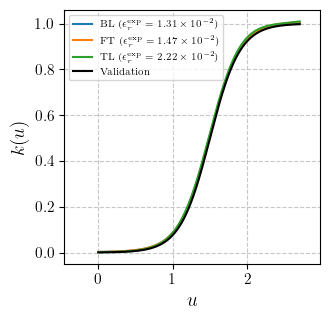

In [24]:
with plt.rc_context({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 10,
    "figure.figsize": (3.3, 3.3),  # Aproximadamente 0.45\linewidth
    "axes.labelsize": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
}):

    plt.figure()
    plt.plot(u_for_validating.flatten(), K_baseline.flatten(), label=f'BL ({format_error_latex(er_baseline)})', linewidth=1.5, alpha=1)
    plt.plot(u_for_validating.flatten(), K_finetuning.flatten(), label=f'FT ({format_error_latex(er_finetuning)})', linewidth=1.5, alpha=1)
    plt.plot(u_for_validating.flatten(), K_transfer.flatten(), label=f'TL ({format_error_latex(er_transfer)})', linewidth=1.5, alpha=1)
    plt.plot(u_for_validating.flatten(), K_for_validating.flatten(), label='Validation', color='black', linewidth=1.5, alpha=1)

    plt.xlabel('$u$', fontsize=label_fontsize)
    plt.ylabel('$k(u)$', fontsize=label_fontsize)
    # plt.title('Lineal homogeneous normalized learning curves', fontsize=s)

    plt.grid(True, linestyle='--', alpha=0.7)
    # Obtener la leyenda actual y cambiar el orden
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0, 1, 2, 3]  # Cambiar el orden de las etiquetas aquí (Validation primero, Prediction segundo)
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='upper left')
    plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

    min = torch.min(u_for_validating.flatten()) - 0.17*(torch.max(u_for_validating.flatten() - torch.min(u_for_validating.flatten())))
    max = torch.max(u_for_validating.flatten()) + 0.1*(torch.max(u_for_validating.flatten() - torch.min(u_for_validating.flatten())))

    plt.xlim(min, max)

    plt.savefig('transfer_learning_N1000.pdf', bbox_inches='tight', format='pdf')
    plt.show()

In [25]:
print("\n===== Summary of Errors (N = 1000) =====\n")
print(f"{'Model':<12} | {'er(K)':>10} | {'er(u) Q1':>10} | {'er(u) Q2':>10} | {'er(u) Q3':>10} |")
print("-" * 66)
print(f"{'Baseline':<12} | {er_baseline:>10.2e} | {erQ1_b:>10.2e} | {erQ2_b:>10.2e} | {erQ3_b:>10.2e} |")
print(f"{'Finetuning':<12} | {er_finetuning:>10.2e} | {erQ1_f:>10.2e} | {erQ2_f:>10.2e} | {erQ3_f:>10.2e} |")
print(f"{'Transfer':<12} | {er_transfer:>10.2e} | {erQ1_t:>10.2e} | {erQ2_t:>10.2e} | {erQ3_t:>10.2e} |")


===== Summary of Errors (N = 1000) =====

Model        |      er(K) |   er(u) Q1 |   er(u) Q2 |   er(u) Q3 |
------------------------------------------------------------------
Baseline     |   1.31e-02 |   8.93e-04 |   1.05e-03 |   1.23e-03 |
Finetuning   |   1.47e-02 |   2.11e-04 |   3.05e-04 |   5.17e-04 |
Transfer     |   2.22e-02 |   2.64e-02 |   4.43e-02 |   6.74e-02 |


In [29]:
# Función para construir cada bloque de datos
def build_df(values, model_name, N):
    return pd.DataFrame({
        'Accuracy': values,
        ' ': [model_name] * len(values),
        'N': [N] * len(values)
    })

df = pd.concat([
    build_df(er_u_baseline_100, 'Baseline', '100'),
    build_df(er_u_finetuning_100, 'Fine-tuning', '100'),
    build_df(er_u_transfer_100, 'Transfer learning', '100'),
    build_df(er_u_baseline_1000, 'Baseline', '1000'),
    build_df(er_u_finetuning_1000, 'Fine-tuning', '1000'),
    build_df(er_u_transfer_1000, 'Transfer learning', '1000'),
], ignore_index=True)

# Colores personalizados
color_map = {'Baseline': '#1276B3', 'Fine-tuning': '#FF7F0E', 'Transfer learning': '#2CA02C'}

C:\Users\usuario\AppData\Local\Temp\ipykernel_8808\1509298246.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_100, x=' ', y='Accuracy', palette=color_map)


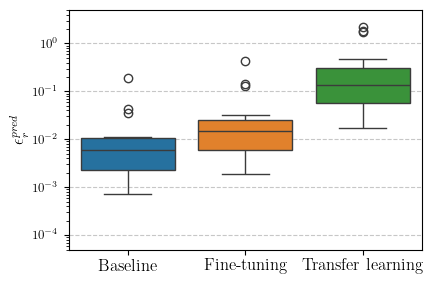

In [30]:
with plt.rc_context({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
    "figure.figsize": (4.5, 3.0),  # Aproximadamente 0.45\linewidth
    "axes.labelsize": 12,
    "legend.fontsize": 7,
    "xtick.labelsize": 12,
    "ytick.labelsize": 9,
}):
    # Primer plot: N = 100
    df_100 = df[df['N'] == '100']
    plt.figure()
    sns.boxplot(data=df_100, x=' ', y='Accuracy', palette=color_map)
    plt.yscale('log')
    plt.ylabel(r'$\epsilon_r^{pred}$')  # etiqueta con LaTeX
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # ← Solo líneas horizontales
    plt.ylim(5e-5, 5)

    plt.savefig('TL_predictive_error_N100.pdf', bbox_inches='tight', format='pdf')
    plt.show()

C:\Users\usuario\AppData\Local\Temp\ipykernel_8808\2052319372.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_100, x=' ', y='Accuracy', palette=color_map)


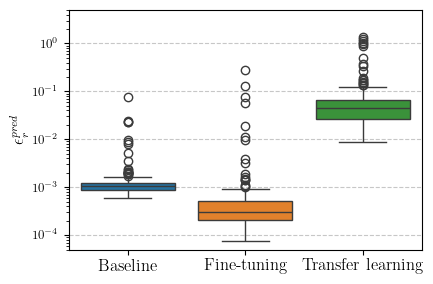

In [31]:
with plt.rc_context({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
    "figure.figsize": (4.5, 3.0),  # Aproximadamente 0.45\linewidth
    "axes.labelsize": 12,
    "legend.fontsize": 7,
    "xtick.labelsize": 12,
    "ytick.labelsize": 9,
}):
    # Primer plot: N = 1000
    df_100 = df[df['N'] == '1000']
    plt.figure()
    sns.boxplot(data=df_100, x=' ', y='Accuracy', palette=color_map)
    plt.yscale('log')
    plt.ylabel(r'$\epsilon_r^{pred}$')  # etiqueta con LaTeX
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # ← Solo líneas horizontales
    plt.ylim(5e-5, 5)

    plt.savefig('TL_predictive_error_N1000.pdf', bbox_inches='tight', format='pdf')
    plt.show()